In this part we'll take our best predictions from previous parts and use them as second-level features for training a second-level regressor.

We'll also use some other features, those who were important for our model in Part 1.

Our cross-validation stategy in this part will be the following: we'll first train our second-level model on data from 2019-2020. We'll also use special versions of predictions from Part 1 and Part 3, which were calculated based only on 2019-2020. Part 2 prediction doesn't have a special version. 

Then we calculate the RMSE score on 2021. This will be our cross-validation RMSE.


In making a submission, we'll use data from 2019-2021, with predictions based on 2019-2021.

Let's load the datasets:

In [179]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
N_SPLITS = global_variables.loc[0, 'N_SPLITS']

train_and_cv_all_features = pd.read_csv('new_datasets/X_train_and_cv_1_final.csv',
                                 index_col='ID_LAT_LON_YEAR_WEEK')
pred_1_train = pd.read_csv('new_datasets/y_train_and_cv_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                            usecols=['ID_LAT_LON_YEAR_WEEK','pred_1_train'])
train_and_cv_all_features['pred_1_train'] = pred_1_train
pred_1 = pd.read_csv('new_datasets/y_train_and_cv_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                            usecols=['ID_LAT_LON_YEAR_WEEK','pred_1'])
train_and_cv_all_features['pred_1'] = pred_1
max_x_groups_train = pd.read_csv('new_datasets/train_3_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                            usecols=['ID_LAT_LON_YEAR_WEEK','Max_x_groups_train'])
train_and_cv_all_features['Max_x_groups_train'] = max_x_groups_train
emission = pd.read_csv('new_datasets/y_train_and_cv_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                            usecols=['ID_LAT_LON_YEAR_WEEK','emission'])
train_and_cv_all_features['emission'] = emission


test_all_features = pd.read_csv('new_datasets/X_test_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK')
pred_1 = pd.read_csv('new_datasets/y_test_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                            usecols=['ID_LAT_LON_YEAR_WEEK','pred_1'])
test_all_features['pred_1'] = pred_1

feature_importances_sorted = pd.read_csv('new_datasets/feature_importances_sorted_1_final.csv', 
                                         index_col=0)

# Break train_and_cv into train (2019-2020) and cv (2021) sets
train_all_features = train_and_cv_all_features.loc[train_and_cv_all_features['year'] < 2021, :]
cv_all_features = train_and_cv_all_features.loc[train_and_cv_all_features['year'] == 2021, :]
 

CPU times: total: 1.2 s
Wall time: 1.67 s


Let's look at feature importances based on the model from Part 1 (this model also used predictions from Part 2 and 3 as features):

In [180]:
print('Sorted feature importances (first 15, pred_1 is not included):')
feature_importances_sorted.head(15)

Sorted feature importances (first 15, pred_1 is not included):


,0
Location_week_no_enc,363
emission_pred_2_04,278
Max_x_groups,217
week_no_enc,173
week_no,153
year,144
Ozone_O3_column_number_density,114
Location_enc,113
latitude,87
Cloud_solar_zenith_angle,62


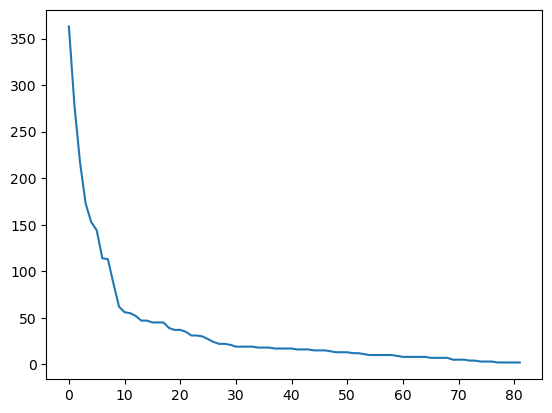

In [181]:
import matplotlib.pyplot as plt
plt.plot(range(0, len(feature_importances_sorted)), feature_importances_sorted)
plt.show()

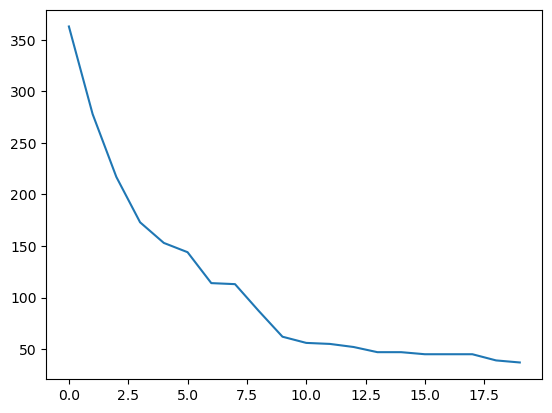

In [182]:
plt.plot(range(0, 20), feature_importances_sorted.head(20))
plt.show()

Let's concentrate on the 9 most important features plus 'pred_1' (prediction of the model from Part 1).

In [183]:
selected_features = list(feature_importances_sorted.iloc[:9, :].index)
selected_features.append('pred_1')

# Create the test set
test = test_all_features[selected_features]

# The target
selected_features.append('emission')

# Create the train_and_cv set
train_and_cv = train_and_cv_all_features[selected_features]

## Create the training and cv sets, special versions of predictions from Part 1 and 3
selected_features.remove('pred_1')
selected_features.append('pred_1_train')
selected_features.remove('Max_x_groups')
selected_features.append('Max_x_groups_train')
train = train_all_features[selected_features]
train.to_csv('new_datasets/train_Stacking_00.csv')
cv = cv_all_features[selected_features]
cv.to_csv('new_datasets/cv_Stacking_00.csv')

In [184]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40754 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2020_52
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Location_week_no_enc            40754 non-null  float64
 1   emission_pred_2_04              40754 non-null  float64
 2   week_no_enc                     40754 non-null  float64
 3   week_no                         40754 non-null  float64
 4   year                            40754 non-null  float64
 5   Ozone_O3_column_number_density  40754 non-null  float64
 6   Location_enc                    40754 non-null  float64
 7   latitude                        40754 non-null  float64
 8   emission                        40754 non-null  float64
 9   pred_1_train                    40754 non-null  float64
 10  Max_x_groups_train              40754 non-null  float64
dtypes: float64(11)
memory usage: 3.7+ MB


## 00. Standard LightGBM, selecting second-level features

In a separate file, namely, ['studies/Stacking_00.py']('studies/Stacking_00.py'), we'll calculate the optimal set of features out of the 10 selected above. That is, we are looking for the set that gives us the lowest cross-validation RMSE.

Note, we used before cross-validation on 2021 in Part 3, the best RMSE was in study 02, it was 19.188561, and the corresponding Test RMSE was 21.67107.

That is our best Test RMSE so far.

Now, let's look at the scores in this study:

In [185]:
%%time

study_number = '00'

import pickle

with open('studies/Stacking_' + study_number + '_params.pkl', 'rb') as f:
    best_params_00 = pickle.load(f)

print("Best hyperparameters:", best_params_00)

Best hyperparameters: {'Location_week_no_enc': False, 'emission_pred_2_04': False, 'week_no_enc': False, 'week_no': True, 'year': True, 'Ozone_O3_column_number_density': True, 'Location_enc': False, 'latitude': True, 'pred_1_train': True, 'Max_x_groups_train': False}
CPU times: total: 0 ns
Wall time: 998 µs


In [186]:
%%time

from sklearn.metrics import mean_squared_error

# UNCOMMENT TO INSTALL
# !pip install lightgbm
import lightgbm as lgb

# Create RMSE DataFrame
scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], 'Cross-val RMSE': [], 'Test RMSE': []})

scores_df.loc[int(study_number), 'Comment'] = 'LightGBM'

## Create the sets with features selected by the hyperparameters search

# For cross-validation
selected_features = [feature for feature, value in best_params_00.items() if value]
train_selected = train[selected_features]
cv_selected = cv[selected_features]

# For submission
if 'pred_1_train' in selected_features:
    selected_features.remove('pred_1_train')
    selected_features.append('pred_1')
if 'Max_x_groups_train' in selected_features:
    selected_features.remove('Max_x_groups_train')
    selected_features.append('Max_x_groups')
train_and_cv_selected = train_and_cv[selected_features]
test_selected = test[selected_features]

## CROSS_VALIDATION
# Instantiate the regressor
model_lgb = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1)

# Fit
model_lgb.fit(train_selected, train['emission'])
# Predict and calculate RMSEs
pred_train = model_lgb.predict(train_selected)
score_train = mean_squared_error(train['emission'], pred_train, squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
pred_cv = model_lgb.predict(cv_selected)
score_cv = mean_squared_error(cv['emission'], pred_cv, squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv

## SUBMISSION
# Fit
model_lgb.fit(train_and_cv_selected, train_and_cv['emission'])
# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': model_lgb.predict(test_selected)})

submission.to_csv('submissions/submission_Stacking_' + study_number + '.csv', index=False)

CPU times: total: 3.64 s
Wall time: 395 ms


In [187]:
scores_df.loc[int(study_number),'Test RMSE'] = np.nan
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,LightGBM,7.515948,13.972098,NaN


## 01. Standard XGBoost, re-selecting second-level features

Now, let's do the same trick as in the previous study, but now we'll work with XRBoost regressor:

In [188]:
study_number = '01'

scores_df.loc[int(study_number), 'Comment'] = 'XGBoost'

train.to_csv('new_datasets/train_Stacking_{}.csv'.format(study_number))
cv.to_csv('new_datasets/cv_Stacking_{}.csv'.format(study_number))

In [189]:
with open('studies/Stacking_' + study_number + '_params.pkl', 'rb') as f:
    best_params_01 = pickle.load(f)

print("Best hyperparameters:", best_params_01)

Best hyperparameters: {'Location_week_no_enc': False, 'emission_pred_2_04': True, 'week_no_enc': True, 'week_no': True, 'year': True, 'Ozone_O3_column_number_density': False, 'Location_enc': True, 'latitude': True, 'pred_1_train': False, 'Max_x_groups_train': False}


In [190]:
%%time

# UNCOMMENT TO INSTALL
# !pip install xgboost
import xgboost as xgb

## Create the sets with features selected by the hyperparameters search

# For cross-validation
selected_features = [feature for feature, value in best_params_01.items() if value]
train_selected = train[selected_features]
cv_selected = cv[selected_features]

# For submission
if 'pred_1_train' in selected_features:
    selected_features.remove('pred_1_train')
    selected_features.append('pred_1')
if 'Max_x_groups_train' in selected_features:
    selected_features.remove('Max_x_groups_train')
    selected_features.append('Max_x_groups')
train_and_cv_selected = train_and_cv[selected_features]
test_selected = test[selected_features]

## CROSS_VALIDATION
# Instantiate the regressor
model_xgb = xgb.XGBRegressor(random_state=SEED, n_jobs=-1)

# Fit
model_xgb.fit(train_selected, train['emission'])
# Predict and calculate RMSEs
pred_train = model_xgb.predict(train_selected)
score_train = mean_squared_error(train['emission'], pred_train, squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
pred_cv = model_xgb.predict(cv_selected)
score_cv = mean_squared_error(cv['emission'], pred_cv, squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv

## SUBMISSION
# Fit
model_xgb.fit(train_and_cv_selected, train_and_cv['emission'])
# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': model_xgb.predict(test_selected)})

submission.to_csv('submissions/submission_Stacking_' + study_number + '.csv', index=False)

CPU times: total: 34.3 s
Wall time: 3.39 s


In [191]:
scores_df.loc[int(study_number),'Test RMSE'] = 34.98748
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,LightGBM,7.515948,13.972098,NaN
1,XGBoost,3.586802,12.204953,34.98748


We can see that XGBoost performed better.

## 02. XGBoost tuned.

 Let's try to do a hyperparameters tuning on XGBoost. The features will be the same as in study 01.

In [192]:
study_number = '02'

scores_df.loc[int(study_number), 'Comment'] = '+ tuned'

train_selected.to_csv('new_datasets/train_Stacking_{}.csv'.format(study_number))
cv_selected.to_csv('new_datasets/cv_Stacking_{}.csv'.format(study_number))

In [193]:
with open('studies/Stacking_' + study_number + '_params.pkl', 'rb') as f:
    best_params_02 = pickle.load(f)

print("Best hyperparameters:", best_params_02)

Best hyperparameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.03965436443186791, 'gamma': 0.7522702749246694, 'min_child_weight': 0.009734727230542055, 'subsample': 0.6, 'colsample_bytree': 1.0, 'num_parallel_tree': 4}


Let's test:

In [194]:
%%time

# Instantiate the regressor
model_xgb = xgb.XGBRegressor(random_state=SEED, n_jobs=-1, **best_params_02)


## CROSS_VALIDATION

# Fit
model_xgb.fit(train_selected, train['emission'])
# Predict and calculate RMSEs
pred_train = model_xgb.predict(train_selected)
score_train = mean_squared_error(train['emission'], pred_train, squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
pred_cv = model_xgb.predict(cv_selected)
score_cv = mean_squared_error(cv['emission'], pred_cv, squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv

## SUBMISSION
# Fit
model_xgb.fit(train_and_cv_selected, train_and_cv['emission'])
# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': model_xgb.predict(test_selected)})

submission.to_csv('submissions/submission_Stacking_' + study_number + '.csv', index=False)

CPU times: total: 2min 57s
Wall time: 18.8 s


In [195]:
scores_df.loc[int(study_number),'Test RMSE'] = np.nan
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,LightGBM,7.515948,13.972098,NaN
1,XGBoost,3.586802,12.204953,34.98748
2,+ tuned,6.784888,11.529942,NaN


## 03. XGBoost feature selection, no Part 2 predictions

The Part 2 predictions were made based mostly on 2021 data, so, in theory, they should cause overfitting to our cross-validation set, which is 2021 data.

Now we'll re-run study 01, but we'll exclude Part 2 predictions frome features:

In [196]:
study_number = '03'

scores_df.loc[int(study_number), 'Comment'] = 'XGBoost, no Part 2'

train.drop('emission_pred_2_04', axis=1).to_csv('new_datasets/train_Stacking_{}.csv'.format(study_number))
cv.drop('emission_pred_2_04', axis=1).to_csv('new_datasets/cv_Stacking_{}.csv'.format(study_number))

In [197]:
with open('studies/Stacking_' + study_number + '_params.pkl', 'rb') as f:
    best_params_03 = pickle.load(f)

print("Best hyperparameters:", best_params_03)

Best hyperparameters: {'Location_week_no_enc': True, 'week_no_enc': False, 'week_no': False, 'year': True, 'Ozone_O3_column_number_density': False, 'Location_enc': False, 'latitude': False, 'pred_1_train': False, 'Max_x_groups_train': False}


In [198]:
%%time

## Create the sets with features selected by the hyperparameters search

# For cross-validation
selected_features = [feature for feature, value in best_params_03.items() if value]
train_selected = train[selected_features]
cv_selected = cv[selected_features]

# For submission
if 'pred_1_train' in selected_features:
    selected_features.remove('pred_1_train')
    selected_features.append('pred_1')
if 'Max_x_groups_train' in selected_features:
    selected_features.remove('Max_x_groups_train')
    selected_features.append('Max_x_groups')
train_and_cv_selected = train_and_cv[selected_features]
test_selected = test[selected_features]

## CROSS_VALIDATION
# Instantiate the regressor
model_xgb = xgb.XGBRegressor(random_state=SEED, n_jobs=-1)

# Fit
model_xgb.fit(train_selected, train['emission'])
# Predict and calculate RMSEs
pred_train = model_xgb.predict(train_selected)
score_train = mean_squared_error(train['emission'], pred_train, squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
pred_cv = model_xgb.predict(cv_selected)
score_cv = mean_squared_error(cv['emission'], pred_cv, squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv

## SUBMISSION
# Fit
model_xgb.fit(train_and_cv_selected, train_and_cv['emission'])
# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': model_xgb.predict(test_selected)})

submission.to_csv('submissions/submission_Stacking_' + study_number + '.csv', index=False)

CPU times: total: 21 s
Wall time: 2.37 s


In [199]:
scores_df.loc[int(study_number),'Test RMSE'] = 30.09157
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,LightGBM,7.515948,13.972098,NaN
1,XGBoost,3.586802,12.204953,34.98748
2,+ tuned,6.784888,11.529942,NaN
3,"XGBoost, no Part 2",6.091798,15.705979,30.09157


Indeed, Cross-val RMSE is higher, but Test RMSE is lower.

## 04. XGBoost tuned, no Part 2 predictions

Let's try to tune this:

In [200]:
study_number = '04'

scores_df.loc[int(study_number), 'Comment'] = '+ tuned'

train_selected.to_csv('new_datasets/train_Stacking_{}.csv'.format(study_number))
cv_selected.to_csv('new_datasets/cv_Stacking_{}.csv'.format(study_number))

In [201]:
with open('studies/Stacking_' + study_number + '_params.pkl', 'rb') as f:
    best_params_04 = pickle.load(f)

print("Best hyperparameters:", best_params_04)

Best hyperparameters: {'n_estimators': 440, 'max_depth': 2, 'learning_rate': 0.02416007069343977, 'gamma': 0.019328921824942846, 'min_child_weight': 0.3354782564036733, 'subsample': 0.4, 'colsample_bytree': 0.6, 'num_parallel_tree': 5}


In [202]:
%%time

# Instantiate the regressor
model_xgb = xgb.XGBRegressor(random_state=SEED, n_jobs=-1, **best_params_04)


## CROSS_VALIDATION

# Fit
model_xgb.fit(train_selected, train['emission'])
# Predict and calculate RMSEs
pred_train = model_xgb.predict(train_selected)
score_train = mean_squared_error(train['emission'], pred_train, squared=False)
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
pred_cv = model_xgb.predict(cv_selected)
score_cv = mean_squared_error(cv['emission'], pred_cv, squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv

## SUBMISSION
# Fit
model_xgb.fit(train_and_cv_selected, train_and_cv['emission'])
pred_train_and_cv = model_xgb.predict(train_and_cv_selected)
pred_test = model_xgb.predict(test_selected)
# Prepare submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': pred_test})

submission.to_csv('submissions/submission_Stacking_' + study_number + '.csv', index=False)

CPU times: total: 2min 25s
Wall time: 15.6 s


In [203]:
scores_df.loc[int(study_number),'Test RMSE'] = 33.3419
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,LightGBM,7.515948,13.972098,NaN
1,XGBoost,3.586802,12.204953,34.98748
2,+ tuned,6.784888,11.529942,NaN
3,"XGBoost, no Part 2",6.091798,15.705979,30.09157
4,+ tuned,8.258166,14.100878,33.34190


## 05. Median of predictions.

For the next set of techniques we'll make DataFrames with predictions only. Our first technique will be to take median of the predictions:

In [204]:
%%time

study_number = '05'

scores_df.loc[int(study_number), 'Comment'] = 'Median'

## Create DataFrames
train_predictions = train[['pred_1_train', 'emission_pred_2_04',
                           'Max_x_groups_train']].copy(deep=True)
train_predictions['pred_Stacking_04_train'] = pred_train

cv_predictions = cv[['pred_1_train', 'emission_pred_2_04',
                     'Max_x_groups_train']].copy(deep=True)
cv_predictions['pred_Stacking_04_train'] = pred_cv

test_predictions = test[['pred_1', 'emission_pred_2_04',
                                         'Max_x_groups']].copy(deep=True)
test_predictions['pred_Stacking_04'] = pred_test

## Calculate Cross-val RMSE
scores_df.loc[int(study_number), 'Train RMSE'] = mean_squared_error(train['emission'],
                                train_predictions.median(axis=1), squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = mean_squared_error(cv['emission'],
                                cv_predictions.median(axis=1), squared=False)


# Prepare a submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test_predictions.median(axis=1)})

submission.to_csv('submissions/submission_Stacking_' + study_number + '.csv', index=False)

CPU times: total: 15.6 ms
Wall time: 77.4 ms


In [205]:
scores_df.loc[int(study_number),'Test RMSE'] = np.nan
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,LightGBM,7.515948,13.972098,NaN
1,XGBoost,3.586802,12.204953,34.98748
2,+ tuned,6.784888,11.529942,NaN
3,"XGBoost, no Part 2",6.091798,15.705979,30.09157
4,+ tuned,8.258166,14.100878,33.34190
5,Median,6.430687,13.560134,NaN


## 06. Mean of predictions.

In [206]:
%%time

study_number = '06'

scores_df.loc[int(study_number), 'Comment'] = 'Mean'

## Calculate Cross-val RMSE
scores_df.loc[int(study_number), 'Train RMSE'] = mean_squared_error(train['emission'],
                                train_predictions.mean(axis=1), squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = mean_squared_error(cv['emission'],
                                cv_predictions.mean(axis=1), squared=False)


# Prepare a submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test_predictions.mean(axis=1)})

submission.to_csv('submissions/submission_Stacking_' + study_number + '.csv', index=False)

CPU times: total: 46.9 ms
Wall time: 60.6 ms


In [207]:
scores_df.loc[int(study_number),'Test RMSE'] = 26.58433
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,LightGBM,7.515948,13.972098,NaN
1,XGBoost,3.586802,12.204953,34.98748
2,+ tuned,6.784888,11.529942,NaN
3,"XGBoost, no Part 2",6.091798,15.705979,30.09157
4,+ tuned,8.258166,14.100878,33.34190
5,Median,6.430687,13.560134,NaN
6,Mean,7.670825,13.372545,26.58433
